# Important to see the Notebook prototyping approach I use before jumping to the .py for deployment

- All of the MLOps + CI/CD work can be found in Jeremiah's repo: https://github.com/Snowflake-Labs/sfguide-data-engineering-with-snowpark-python?_fsi=ua2IK1xV \

- Link to the quickstart with a good write up on the repo: https://quickstarts.snowflake.com/guide/data_engineering_pipelines_with_snowpark_python/index.html?index=..%2F..index#1 \


# Snowpark ML - Hands-on Lab

### Objective 

In this session, we will be using the diamonds data set which is widely known and used within the DS community. We’ll ingest it into a Snowpark dataframe from an external stage in S3. The overall goal of this ML project is to predict the price of diamonds given different qualitative and quantitative attributes

In this Notebook, we will:

* Load, clean, and transform your feature data with SnowML functions + train your models using popular Python ML frameworks such as scikit-learn, xgboost, and lightgbm without moving data out of Snowflake.
* Streamline model management and batch inference with built-in versioning support and role-based access control catering to both Python and SQL users with the 
* Keep your ML pipeline running within Snowflake's security and governance perimeters
* Take advantage of the performance and scalability of Snowflake's scalable computing platform


## SET UP
### Step 1 - Import Libraries

In [15]:
# --->  REMOVE PYSPARK REFERENCES

# import pyspark.sql.functions as f
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import udf,col
# from pyspark.sql.types import IntegerType
# spark = SparkSession.builder.appName("DataEngeering1").getOrCreate()

# <---  REPLACE WITH SNOWPARK REFERENCES (Rest of code is almost identical) 


# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark import types as T

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml #MMS,OE,OHE
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import Registry
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error, mean_squared_error
from snowflake.ml._internal.utils import identifier


# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import json
import joblib
import ast
import logging
import re

# warning suppresion
import warnings; warnings.simplefilter('ignore')

### STEP 2 - Establish Secure Connection to Snowflake
Using the Snowpark API, it’s quick and easy to establish a secure connection between Snowflake and Notebook.

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

In [14]:
# Make a Snowpark Connection

################################################################################################################
#  You can also use the SnowSQL Client to configure your connection params:
#  https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
#
#  >>> from snowflake.ml.utils import connection_params
#  >>> session = Session.builder.configs(connection_params.SnowflakeLoginOptions()
#  >>> ).create()   
#
#  NOTE: If you have named connection params then specify the connection name
#  Example:
#  
#  >>> session = Session.builder.configs(
#  >>> connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
#  >>> ).create()
#
#################################################################################################################

# Edit the connection.json before creating the session object below
# Create Snowflake Session object
connection_parameters = json.load(open('../secrets/connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : RARRANZ
Role                        : "SYSADMIN"
Database                    : "ML_HOL_DB"
Schema                      : "ML_HOL_SCHEMA"
Warehouse                   : "ML_HOL_WH"
Snowflake version           : 8.13.1
Snowpark for Python version : 1.12.0


## Data Ingestion
### STEP 3 - Use the Snowpark DataFrame Reader to read in data from the externally staged `diamonds` CSV file 

In setup.sql, we staged the `diamonds.csv` file from an external s3 bucket. Now, we can read it in.

For more information on loading data, see documentation on [snowflake.snowpark.DataFrameReader](https://docs.snowflake.com/ko/developer-guide/snowpark/reference/python/api/snowflake.snowpark.DataFrameReader.html).


In [16]:
# Show the file before loading
session.sql("LS @DIAMONDS_ASSETS;").show()

# Create a Snowpark DataFrame that is configured to load data from the CSV file
# We can now infer schema from CSV files.
diamonds_df = session.read.options({"field_delimiter": ",",
                                    "field_optionally_enclosed_by": '"',
                                    "infer_schema": True,
                                    "parse_header": True}).csv("@DIAMONDS_ASSETS")
# SNOWFLAKE ADVANTAGE: Snowpark Dataframe API 
# SNOWFLAKE ADVANTAGE: Schema inference

#SQL query explain plan
diamonds_df.explain()

-----------------------------------------------------------------------------------------------------------------------------------
|"name"                                              |"size"   |"md5"                             |"last_modified"                |
-----------------------------------------------------------------------------------------------------------------------------------
|s3://sfquickstarts/intro-to-machine-learning-wi...  |2772143  |4d3d1d4bbad5e0806dbaec425cf90196  |Mon, 10 Jul 2023 22:04:47 GMT  |
-----------------------------------------------------------------------------------------------------------------------------------

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
CREATE SCOPED TEMPORARY FILE  FORMAT  If  NOT  EXISTS "ML_HOL_DB"."ML_HOL_SCHEMA".SNOWPARK_TEMP_FILE_FORMAT_6ZSBXADUM5 TYPE  = CSV  FIELD_DELIMITER = ',' FIELD_OPTIONALLY_ENCLOSED_BY = '"' SKIP_HEADER = 1
---
2.
SELECT $1::NUMBER(3, 2) AS "carat", $2::TEXT AS "cut", $3::TEXT AS "

### STEP 4 - Data Exploration &  Table Definitions

In [17]:
#preview diamonds data
diamonds_df.show()
# Look at descriptive stats on the DataFrame
diamonds_df.describe().show()

------------------------------------------------------------------------------------------------
|"carat"  |"cut"      |"color"  |"clarity"  |"depth"  |"table"  |"price"  |"x"   |"y"   |"z"   |
------------------------------------------------------------------------------------------------
|0.23     |Ideal      |E        |SI2        |61.5     |55.0     |326      |3.95  |3.98  |2.43  |
|0.21     |Premium    |E        |SI1        |59.8     |61.0     |326      |3.89  |3.84  |2.31  |
|0.23     |Good       |E        |VS1        |56.9     |65.0     |327      |4.05  |4.07  |2.31  |
|0.29     |Premium    |I        |VS2        |62.4     |58.0     |334      |4.20  |4.23  |2.63  |
|0.31     |Good       |J        |SI2        |63.3     |58.0     |335      |4.34  |4.35  |2.75  |
|0.24     |Very Good  |J        |VVS2       |62.8     |57.0     |336      |3.94  |3.96  |2.48  |
|0.24     |Very Good  |I        |VVS1       |62.3     |57.0     |336      |3.95  |3.98  |2.47  |
|0.26     |Very Good  |H      

### STEP 5 - Data Cleaning
* First, let's force headers to uppercase using Snowpark DataFrame operations and rename_columns_all_caps functions for standardization purposes.

* Next, we standardize the category formatting for `CUT` using Snowpark DataFrame operations.

This way, when we write to a Snowflake table, there will be no inconsistencies in how the Snowpark DataFrame will read in the category names. Secondly, the feature transformations on categoricals will be easier to encode.

In [19]:
#5.1 - UPPERCASE ALL COLUMN NAMES
for colname in diamonds_df.columns:
    if colname == '"table"':
       new_colname = "TABLE_PCT"
    else:
        new_colname = str.upper(colname)
    diamonds_df = diamonds_df.with_column_renamed(colname, new_colname)

#5.2  - UPPERCASE STRING VALUES (CUT)
def fix_values(columnn):
    return F.upper(F.regexp_replace(F.col(columnn), '[^a-zA-Z0-9]+', '_'))

for col in ["CUT"]:
    diamonds_df = diamonds_df.with_column(col, fix_values(col))

#SQL query explain plan
diamonds_df.explain()


---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
CREATE SCOPED TEMPORARY FILE  FORMAT  If  NOT  EXISTS "ML_HOL_DB"."ML_HOL_SCHEMA".SNOWPARK_TEMP_FILE_FORMAT_6ZSBXADUM5 TYPE  = CSV  FIELD_DELIMITER = ',' FIELD_OPTIONALLY_ENCLOSED_BY = '"' SKIP_HEADER = 1
---
2.
SELECT "CARAT", "COLOR", "CLARITY", "DEPTH", "TABLE_PCT", "PRICE", "X", "Y", "Z", upper(regexp_replace("CUT", '[^a-zA-Z0-9]+', '_', 1, 0)) AS "CUT" FROM ( SELECT "CARAT", "COLOR", "CLARITY", "DEPTH", "TABLE_PCT", "PRICE", "X", "Y", "Z", "CUT" AS "CUT" FROM ( SELECT "CARAT" AS "CARAT", "COLOR" AS "COLOR", "CLARITY" AS "CLARITY", "DEPTH" AS "DEPTH", "TABLE_PCT" AS "TABLE_PCT", "PRICE" AS "PRICE", "X" AS "X", "Y" AS "Y", "Z" AS "Z", upper(regexp_replace("CUT", '[^a-zA-Z0-9]+', '_', 1, 0)) AS "CUT" FROM ( SELECT "carat" AS "CARAT", "cut" AS "CUT", "color" AS "COLOR", "clarity" AS "CLARITY", "depth" AS "DEPTH", "table" AS "TABLE_PCT", "price" AS "PRICE", "x" AS "X", "y" AS "Y", "z" AS "Z" FROM ( SELECT $1::NUMBER(3, 2) AS "c

In [20]:
#Preview cleaned data
diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |
----------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |61.5     |55.0         |326      |3.95  |3.98  |2.43  |IDEAL      |
|0.21     |E        |SI1        |59.8     |61.0         |326      |3.89  |3.84  |2.31  |PREMIUM    |
|0.23     |E        |VS1        |56.9     |65.0         |327      |4.05  |4.07  |2.31  |GOOD       |
|0.29     |I        |VS2        |62.4     |58.0         |334      |4.20  |4.23  |2.63  |PREMIUM    |
|0.31     |J        |SI2        |63.3     |58.0         |335      |4.34  |4.35  |2.75  |GOOD       |
|0.24     |J        |VVS2       |62.8     |57.0         |336      |3.94  |3.96  |2.48  |VERY_GOOD  |
|0.24     |I        |VVS1       |62.3     |57.0         |336      |3.95  |3.98  |2.47  |VER

### SKIP TO NEXT BLOCK 
- NEED TO PACKAGE UP AND IMPORT TYLER'S UPPERCASE FUNCTIONS IN COMMON.PY

In [27]:
def convert_to_all_caps(c):
    """
    Converts a given string to all capital letters and separates words with underscores.

    Args:
        c (str): The input string to be converted.

    Returns:
        str: The converted string with all capital letters and underscores separating words.
    """
    return re.sub(
        r"(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])",
        "_",
        c,
    ).upper()

def rename_columns_all_caps(diamonds_df):
    """
    Renames all columns in the DataFrame to uppercase.

    Args:
        df (snowpark.DataFrame): The input DataFrame.

    Returns:
        snowpark.DataFrame: The DataFrame with all column names converted to uppercase.
    """
    return diamonds_df.to_df([convert_to_all_caps(c) for c in diamonds_df.columns])

diamonds_df = rename_columns_all_caps(diamonds_df)

### STEP 6 - Data Serving
Write cleaned data to a Snowflake table

In [21]:
#write diamonds data to Snowflake table
diamonds_df.write.save_as_table("Diamonds", mode="overwrite")
# SNOWFLAKE ADVANTAGE: Snowflake Tables (not file-based)

print("Created Diamonds table with diamonds_df inferred schema!")

Created Diamonds table with diamonds_df inferred schema!


## Dynamic Feature Engineering
### STEP 7 - Select numerical and categorical `feature` columns from the `diamonds` schema 

Categorize all the `features` for processing! This will be useful for both the ML training & inference steps to have standarized feature transformations.

7.1  - Read clean diamonds table into snowpark dataframe

In [8]:
# Read DIAMONDS table back into a snowpark diamonds_df
diamonds_df = session.table('"ML_HOL_DB"."ML_HOL_SCHEMA".Diamonds')


7.2 - Manual Feature Selection - WRONG WAY! SKIP TO NEXT BLOCK

In [9]:
# 7.2 - SKIP - WRONG WAY OF DOING THIS! 
#Categorize all the features for processing
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = [ "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
CATEGORICAL_COLUMNS_OHE = ["CUT_OHE"]
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}



7.3 Dynamically select ALL numerical feature columns from diamonds_df schema `CARAT`, `DEPTH`, `TABLE_PCT`, `X`, `Y`, `Z` to normalize using `MinMaxScaler` 

In [23]:
# Define the label column
output_actual = ['PRICE']

# # What are the numeric columns? ...'CARAT', 'DEPTH', 'TABLE_PCT', 'X', 'Y', 'Z'
# Define Snowflake numeric types
numeric_types = [T.DecimalType, T.DoubleType, T.FloatType, T.IntegerType, T.LongType]

# # Get numeric columns to min max scale
cols_to_scale = [col.name for col in diamonds_df.schema.fields if type(col.datatype) in numeric_types]

# remove the output
cols_to_scale.remove('PRICE')
scale_cols_output = [col + '_NORM' for col in cols_to_scale]
print(cols_to_scale)
print(scale_cols_output)

['CARAT', 'DEPTH', 'TABLE_PCT', 'X', 'Y', 'Z']
['CARAT_NORM', 'DEPTH_NORM', 'TABLE_PCT_NORM', 'X_NORM', 'Y_NORM', 'Z_NORM']


7.4 - Dynamically select categorical (string) feature columns from diamonds_df schema `COLOR`, `CUT` and `CLARITY`to transform into numerical values using `OrdinalEncoder`  or `OneHotEncoder`

In [24]:
# # What are the categorical columns?
# # Define Snowflake categorical types
categorical_types = [T.StringType]

# # Get categorical columns
cat_cols = [col.name for col in diamonds_df.schema.fields if type(col.datatype) in categorical_types]
print(cat_cols)

['COLOR', 'CLARITY', 'CUT']


7.5  - Dynamically define input columns and output columns for `OrdinalEncoder`  or `OneHotEncoder` 

In [25]:

# We COULD ordinally encode all of these columns. However for the sake of the demo we will OHE 'CUT'.
cols_to_ohe = ['CUT']

# ohe_cols_output = diamonds_df.select("CUT").distinct().to_pandas()
# ohe_cols_output = ohe_cols_output['CUT'].tolist()
# display(ohe_cols_output)
# ohe_cols_output = [col + '_OHE' for col in ohe_cols_output]
ohe_cols_output = [col + '_OHE' for col in cols_to_ohe]

# So I could typcially just list the smaller of the two sets (ones to OE or OHE) and then do list subraction to set the larger list dynamically.
# I do this so I only have to explicitly define the smaller of the two categorical lists (either OHE or OE)
set1 = set(cat_cols)
set2 = set(cols_to_ohe)
cols_to_oe = list(set1 - set2)
oe_cols_output = [col + '_OE' for col in cols_to_oe]

print(cols_to_oe)
print(oe_cols_output)
print(cols_to_ohe)
print(ohe_cols_output)

['CLARITY', 'COLOR']
['CLARITY_OE', 'COLOR_OE']
['CUT']
['CUT_OHE']


## Pre-processing + Model Training

### STEP 8 - Build the `scikitlearn` Pre-processing and `XGBReg` Model Training Pipeline using the `Snowpark ML Modeling API`

Build the pre-processing + training pipeline

In [26]:
# ~4.5min WITH XS --> 3min 35s WITH S --> 2min 40S WITH M --> 2min 15s WITH L 
# 8.1 - Define the arrays of values for each categorical features
categories = {
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}
#8.2  - define the parameters for model training
parameters = {
"n_estimators":[100, 200, 300, 400, 500],
"learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5],
}

#8.3 - Define the pre-processing steps
#SNOWML ADVANTAGE: Hyper-parallelization and Code Abstraction
#SNOWML ADVANTAGE: SQL Pushdown Optimization
# 1) MinMax scale 'CARAT', 'DEPTH', 'TABLE_PCT', 'X', 'Y', 'Z'
snowml_mms = snowml.MinMaxScaler(
                clip=True,
                input_cols=cols_to_scale,
                output_cols=scale_cols_output,
            )
# 2) Ordinal Encode COLOR, CLARITY from categorical to numerical
snowml_oe = snowml.OrdinalEncoder(
                input_cols=cols_to_oe,
                output_cols=oe_cols_output,
                categories=categories,
                drop_input_cols=True,
            )
# 3) One Hot Encode CUT from categorical to numerical
snowml_ohe = snowml.OneHotEncoder(
                input_cols=cols_to_ohe,
                output_cols=ohe_cols_output,
                drop_input_cols=True,
            )

#8.4 - Gridsearch cross validation on XGBRegressor
# scale compute up for hyperparameter tuning
session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=MEDIUM;").collect()
snowml_gscv = GridSearchCV(
                estimator=XGBRegressor(),
                param_grid=parameters,
                n_jobs = -1,
                scoring="neg_mean_absolute_percentage_error",
                #input_cols= model_input_cols,
                #passthrough_cols="UNIQUE_KEY",
                label_cols=output_actual,
                output_cols=['PREDICTED_PRICE']
            )

#8.5 Create pipeline
pipeline = Pipeline(
[("MMS", snowml_mms), ("OE", snowml_oe), ("OHE", snowml_ohe),("XGBReg_GSCV", snowml_gscv)]
)

#8.6 Split data, Train the model & Make/Show Predictions
train_df, test_df = diamonds_df.random_split([0.8, 0.2], seed=42)
pipeline.fit(train_df)
result_df = pipeline.predict(train_df)
result_df.show()

#8.7 - Calculate Accuracy Metrics - MAPE & MSE
LABEL_COLUMNS = ['PRICE']
OUTPUT_COLUMNS = ['PREDICTED_PRICE']
metrics = {
    "Mean absolute percentage error": mean_absolute_percentage_error(
        df=result_df, 
        y_true_col_names=LABEL_COLUMNS, 
        y_pred_col_names=OUTPUT_COLUMNS
    ),
    "Mean squared error": mean_squared_error(
        df=result_df, 
        y_true_col_names=LABEL_COLUMNS, 
        y_pred_col_names=OUTPUT_COLUMNS
    ),
}
#View accuracy metrics
result_df.select([*LABEL_COLUMNS, *OUTPUT_COLUMNS]).show()
print("Model has been trained and evaluated!")
print(f'''Mean absolute percentage error: {metrics["Mean absolute percentage error"]}''')
print(f'''Mean squared error: {metrics["Mean squared error"]}''')



Package 'fastparquet' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.
The version of package 'pyarrow' in the local environment is 15.0.0, which does not fit the criteria for the requirement 'pyarrow<14'. Your UDF might not work when the package version is different between the server and your local environment.


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUT_OHE_GOOD"  |"TABLE_PCT"  |"CUT_OHE_FAIR"  |"CUT_OHE_PREMIUM"  |"CUT_OHE_VERY_GOOD"  |"DEPTH"  |"X"   |"Y_NORM"             |"X_NORM"             |"CUT_OHE_IDEAL"  |"Y"   |"CARAT"  |"DEPTH_NORM"         |"Z_NORM"             |"Z"   |"TABLE_PCT_NORM"     |"PRICE"  |"COLOR_OE"  |"CARAT_NORM"           |"CLARITY_OE"  |"PREDICTED_PRICE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# scale compute down after hyperparameter tuning
session.sql("ALTER WAREHOUSE ML_HOL_WH SET WAREHOUSE_SIZE=XSMALL;").collect()

[Row(status='Statement executed successfully.')]

8.8 - Viusalizations - plot actual vs predicted using `saeborn` replot function

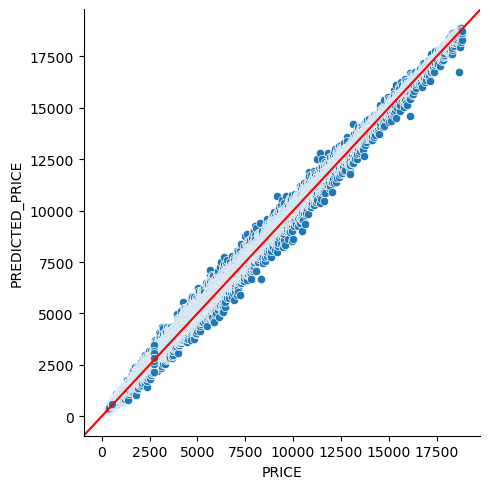

In [28]:
#8.8 - Plot actual vs predicted 
g = sns.relplot(data=result_df["PRICE", "PREDICTED_PRICE"].to_pandas().astype("float64"), x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

# MLOps 
### STEP 9 - Model Management using `MLOps API`

Now, with Snowpark ML's  model registry, we have a Snowflake native model versioning and deployment framework. This allows us to log models, tag parameters and metrics, track metadata, create versions, and ultimately execute batch inference tasks in a Snowflake warehouse or deploy to a Snowpark Container Service for live inference

9.2  - First, we define model versioning function

In [30]:
# Model Versioning function - need to package it and import it from common.py 
def get_next_version(reg, model_name) -> str:
    """
    Returns the next version of a model based on the existing versions in the registry.

    Args:
        reg: The registry object that provides access to the models.
        model_name: The name of the model.

    Returns:
        str: The next version of the model in the format "V_<version_number>".

    Raises:
        ValueError: If the version list for the model is empty or if the version format is invalid.
    """
    models = reg.show_models()
    if models.empty:
        return "V_1"
    elif model_name not in models["name"].to_list():
        return "V_1"
    max_version_number = max(
        [
            int(version.split("_")[-1])
            for version in ast.literal_eval(
                models.loc[models["name"] == model_name, "versions"].values[0]
            )
        ]
    )
    return f"V_{max_version_number + 1}"

9.2  - Next, we will log our models and performance metrics.

In [32]:
#9.2 - LOGGING MODEL + METRICS IN REGISTRY
reg = Registry(session=session, database_name="ML_HOL_DB", schema_name="ML_HOL_SCHEMA")
reg.log_model(
    model_name="DIAMONDS_PRICE_PREDICTION",
    version_name=get_next_version(reg, "DIAMONDS_PRICE_PREDICTION"),
    model=pipeline,
    metrics=metrics,
)
print("Model Version and Metrics have been logged in Registry!")
reg_df = reg.show_models()
display(reg_df)

Model Version and Metrics have been logged in Registry!


,created_on,name,database_name,schema_name,comment,owner,default_version_name,versions
0,2024-04-03 11:29:34.471000-07:00,DIAMONDS_PRICE_PREDICTION,ML_HOL_DB,ML_HOL_SCHEMA,None,SYSADMIN,V_1,"[""V_1"",""V_2""]"


9.3 - Sort model version based on accuracy in order to deploy the best model for batch inference!

In [33]:
# 9.3 - Get the model
# first creates a Registry object or uses existing one, which is used to manage models in Snowflake.
reg = Registry(session=session, database_name="ML_HOL_DB", schema_name="ML_HOL_SCHEMA")

# retrieves all the models in the registry and stores them in reg_df.
reg_df = reg.show_models()

# specifies the name of the model to use for prediction
model_name = 'DIAMONDS_PRICE_PREDICTION'
print("Model version for deployment has been selected:")
# Retrieves the specified model and its versions.
reg_df = reg.get_model(model_name).show_versions()
# print(reg_df.metadata)

# # Adds a new column "Mean absolute percentage rrror" to reg_df by extracting it from the metadata of each version.
reg_df["Mean absolute percentage error"] = reg_df["metadata"].apply(
        lambda x: json.loads(x)["metrics"]["Mean absolute percentage error"]
     )
# # sorts the versions by accuracy in descending order and selects the version with the highest accuracy as the deployed version.
best_model = reg_df.sort_values(by="Mean absolute percentage error", ascending=False)
deployed_version = best_model["name"].iloc[0]

# # Sets the default version of the model to the deployed version.
m = reg.get_model(model_name)
m.default = deployed_version
mv = m.default
mv.version_name





Model version for deployment has been selected:


'V_1'

## Deploy model for Batch Inference on test `diamonds` data

In [34]:

#diamonds_df = session.table('"ML_HOL_DB"."ML_HOL_SCHEMA".diamonds') # reads like SELECT * FROM DIAMONDS; in SQL
test_df.show()

print(mv.show_functions())
remote_prediction = mv.run(test_df, function_name='predict') # https://docs.snowflake.com/en/developer-guide/snowpark-ml/reference/latest/api/model/snowflake.ml.model.ModelVersion
remote_prediction.show()

remote_prediction = mv.run(test_df.limit(1), function_name='predict')
remote_prediction.show()


----------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |
----------------------------------------------------------------------------------------------------
|0.23     |E        |VS1        |56.9     |65.0         |327      |4.05  |4.07  |2.31  |GOOD       |
|0.24     |J        |VVS2       |62.8     |57.0         |336      |3.94  |3.96  |2.48  |VERY_GOOD  |
|0.24     |I        |VVS1       |62.3     |57.0         |336      |3.95  |3.98  |2.47  |VERY_GOOD  |
|0.22     |F        |SI1        |60.4     |61.0         |342      |3.88  |3.84  |2.33  |PREMIUM    |
|0.23     |H        |VS1        |61.0     |57.0         |353      |3.94  |3.96  |2.41  |VERY_GOOD  |
|0.23     |F        |VS1        |60.9     |57.0         |357      |3.96  |3.99  |2.42  |VERY_GOOD  |
|0.23     |F        |VS1        |59.8     |57.0         |402      |4.04  |4.06  |2.42  |VER

In [56]:

print("Predictions written back to Snowflake table!")
remote_prediction.write.save_as_table("Diamonds_Predictions", mode="overwrite")

------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"  |
------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |61.5     |55.0         |326      |3.95  |3.98  |2.43  |IDEAL  |
------------------------------------------------------------------------------------------------

Predictions written back to Snowflake table!


## WIP - Batch Inference on new `diamonds` data

In [ ]:
# create stream (CDC) on diamonds table to capture new diamonds data
_ = session.sql("CREATE STREAM ML_HOL_SCHEMA.DIAMONDS_STREAM ON TABLE ML_HOL_SCHEMA.DIAMONDS").collect()
# create new target table for fresh diamonds data
_ = session.sql("CREATE TABLE ML_HOL_SCHEMA.DIAMONDS_2 LIKE ML_HOL_SCHEMA.DIAMONDS").collect()
# 
# Retrieves the source and target tables from the database.
source = session.table('ML_HOL_DB.ML_HOL_SCHEMA.DIAMONDS_STREAM')
target = session.table('ML_HOL_DB.ML_HOL_SCHEMA.DIAMONDS_2')

# runs the prediction function of the model on the source table and stores the predictions in preds.
preds =  mv.run(source, function_name="predict")

# prepares the updates to be made to the target table. 
# The updates include all columns in the predictions that do not contain ‘METADATA’ in their names, and a ‘META_UPDATED_AT’ column that records the current timestamp.
# TODO: Is the if clause supposed to be based on "META_UPDATED_AT"?
cols_to_update = {c: source[c] for c in preds.schema.names if "METADATA" not in c}
metadata_col_to_update = {"META_UPDATED_AT": F.current_timestamp()}
updates = {**cols_to_update, **metadata_col_to_update}

# merges the predictions into the target table DIAMONDS based on the ‘ID_COL’ column. 
# If a row in the target table matches a row in the predictions, it updates the row with the updates; if not, it inserts a new row with the updates
target.merge(preds, target['ID_COL'] == source['ID_COL'], \
                    [F.when_matched().update(updates), F.when_not_matched().insert(updates)])

# Finally, it returns a message indicating that the batch prediction is complete.
# you could return the number of rows inserted or updated here if you would like by getting length of F.when_matched() and F.when_not_matched()
return "Batch prediction complete! 

## Appendix
#### Execute batch inference using a Vectorized UDF & Pandas

In case you have an existing model outside of our supported frameworks (scikit-learn, xgboost, lightgbm, pytorch, tensorflow, pyfunc), you can still execute batch inference via Vectorized UDFs.

Make sure to add your package to the `packages` section in the UDF registration call.

In [ ]:
# Let's save our optimal model first
MODEL_FILE = 'model.joblib'
joblib.dump(optimal_model, MODEL_FILE) # we are just pickling it locally first

# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@ML_HOL_ASSETS", overwrite=True)

# Get all relevant column names to pass into the UDF call
feature_cols = test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].columns

In [ ]:
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_diamond', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@ML_HOL_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@ML_HOL_ASSETS/model.joblib.gz'],
     packages=['pandas','joblib','cachetools','xgboost'])
def batch_predict_diamond(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = ["CUT_OE", "COLOR_OE", "CLARITY_OE", 'CARAT', 'DEPTH', 'TABLE_PCT', 'X', 'Y', 'Z']
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's

Call Vectorized User-Defined Function (UDF) on test data.

In [ ]:
test_df_w_preds = test_df.with_column('PREDICTED_PRICE', batch_predict_diamond(*feature_cols))
test_df_w_preds.show()